In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Preliminary"

donotdelete = []

Welcome to JupyROOT 6.10/08


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [4]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

# Cuts declaration

In [5]:
analysis_cuts = [
 'mass_mumu < 3.174',
 'mass_mumu > 3.013',
 'mass_piK > 0.82',
 'mass_piK < 0.96',
 'mum_pt > 3.5',
 'mup_pt > 3.5',
 'Jpsi_pt > 6.9',
 'pval_mumu > 0.1',
 'mum_eta > -2.2',
 'mup_eta > -2.2',
 'mum_eta < 2.2',
 'mup_eta < 2.2',
 'cosT_Jpsi_PV > 0.95',
 'mum_dxy < 3',
 'mup_dxy < 3',
 'pval_piK > 0.1',
 'fabs(mass_piK - 0.892) < fabs(mass_piK_CPconj - 0.892)',
 'mass_KK > 1.035',
 'K_sigdxy_PV > 2',
 'pi_sigdxy_PV > 2',
 'sigdxy_vtxKst_PV > 5',
 'K_pt > 0.8',
 'pval_mumupiK > 0.1',
 'pi_pt > 0.8',
 'mass_mumupiK > 5.02',
 'mass_mumupiK < 5.55'
]
analysis_cuts_str = ' && '.join(analysis_cuts)

# Load data

In [6]:
dataDir = '../data/cmsRD'
datasets_loc = []
# datasets_loc += glob(dataDir + '/ParkingBPH[12]/*B2JpsiKst_191002*')
# datasets_loc += glob(dataDir + '/ParkingBPH3/*B2JpsiKst_191003*')

datasets_loc += glob(dataDir + '/ParkingBPH1/*2018D-*B2JpsiKst_191017*')

In [7]:
lumi_tot, lumi_dic = getLumiReport(datasets_loc)
CMS_lumi.integrated_lumi = lumi_tot

Lumi tot: 5.3 fb^-1
Lumi analyzed: 12.8%


In [8]:
treeRD = rt.TChain('outA/Tevts')
for floc in datasets_loc:
   treeRD.Add(floc)
print 'N evts: {:.0f}'.format(treeRD.GetEntries(analysis_cuts_str))

N evts: 19863


# Load MC

In [9]:
mcDir = '../data/cmsMC_private'
mcsets_loc = []
mcsets_loc += glob(mcDir + '/BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU20_10-2-3/jobs_B2JpsiKst/out_CAND*.root')

In [10]:
treeMC = rt.TChain('outA/Tevts')
for floc in mcsets_loc:
   treeMC.Add(floc)
print 'N evts: {:.0f}'.format(treeMC.GetEntries(analysis_cuts_str))

N evts: 11813


# Analyze data

In [11]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=[30, 5.02, 5.55]
               )
treeRD.Project('h', 'mass_mumupiK', analysis_cuts_str)
h.Sumw2()

In [12]:
N_tot = h.Integral(1, h.binning[0])
print N_tot
print h.Integral()

19895.0
19895.0


In [84]:
mass = rt.RooRealVar('mass_mumupiK', 'm_{#mu#mu#piK}', h.binning[1], h.binning[2], 'GeV')

# mean = rt.RooRealVar('mean', 'm_{B}', m_B0, 3, 7, 'GeV')
# sigma = rt.RooRealVar('sigma', '#sigma', 0.02, 0.00005, 0.1, 'GeV') 
# pdf_sig = rt.RooGaussian('gaus','sig pdf', mass, mean, sigma)

# mean = rt.RooRealVar('mean', 'm_{B}', m_B0, 3, 7, 'GeV')
# sigma = rt.RooRealVar('sigma', '#sigma', 0.03, 0.00005, 0.1, 'GeV')
# alpha = rt.RooRealVar('alpha', '#alpha', 2, -5, 5, 'GeV')
# nCB = rt.RooRealVar('nCB', 'n_{CB}', 2, -10, 10, 'GeV')
# pdf_sig = rt.RooCBShape('gaus','sig pdf', mass, mean, sigma, alpha, nCB)

mean = rt.RooRealVar('mean', '#mu', m_B0, 3, 7, 'GeV')
sigma = rt.RooRealVar('sigma', '#sigma', 0.03, 0.00005, 0.1, 'GeV')
pAsym = rt.RooRealVar('pAsym', '#alpha', 0, -1, 1)
pAsym.setConstant(rt.kTRUE)
rho1 = rt.RooRealVar('rho1', '#rho_{1}', 0, -10, 0)
rho1.setConstant(rt.kTRUE)
rho2 = rt.RooRealVar('rho2', '#rho_{2}', 0.5, 0, 10)
pdf_sig = rt.RooBukinPdf('bukin','sig pdf', mass, mean, sigma, pAsym, rho1, rho2)


nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 100*N_tot)
pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)

In [85]:
lam = rt.RooRealVar('lam', '#lambda', -2.1, -100, -0.1, 'GeV^{-1}')
pdf_bkg = rt.RooExponential('expo', 'bkg pdf', mass, lam)

# a0 = rt.RooRealVar('a0', 'a0', 10, 0, 100)
# a1 = rt.RooRealVar('a1', 'a1', 0.1, -10, 1000)
# a2 = rt.RooRealVar('a2', 'a2', 0.1, -100, 1000)
# pdf_bkg = rt.RooPolynomial('poly', 'bkg pdf', mass, rt.RooArgList(a1, a2), 1)

nbkg = rt.RooRealVar('nbkg', 'N_{B}', 0.1*N_tot, 0, 100*N_tot)
pdf_bkg_ext = rt.RooExtendPdf('ebkg', 'ebkg', pdf_bkg, nbkg)

In [86]:
data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)

pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_sig_ext, pdf_bkg_ext))
fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())

dof = h.binning[0]-fr.floatParsFinal().getSize()
chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
pval = rt.ROOT.Math.chisquared_cdf_c(chi2.getVal(), dof)
print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2.getVal(), dof, pval)

print 'Total: Nsig = {:.0f}, Nbkg = {:.0f}'.format(nsig.getVal(), nbkg.getVal())

chi2: 35.5/24 0.061
Total: Nsig = 14622, Nbkg = 5273


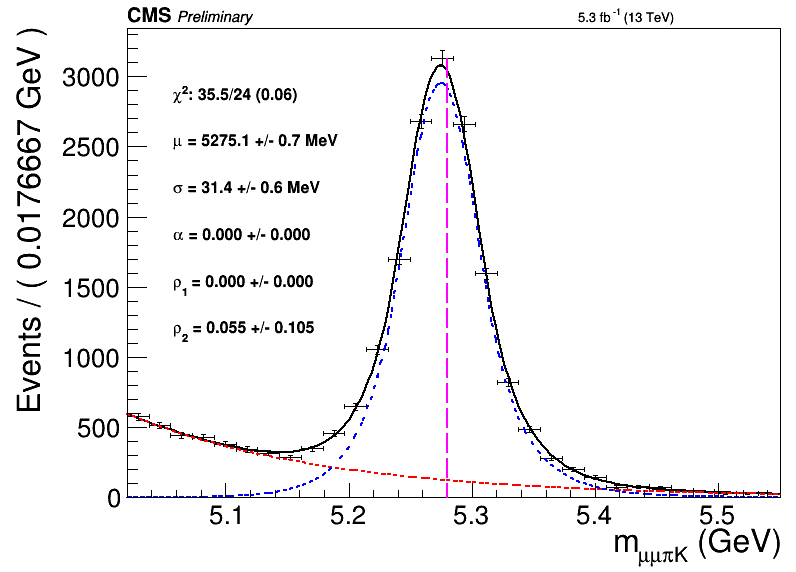

In [87]:
frame = mass.frame(rf.Title(""))
data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), rf.MarkerColor(h.GetLineColor()), rf.LineColor(h.GetLineColor()))
pdf_tot.plotOn(frame, rf.LineColor(h.GetLineColor()), rf.LineWidth(2))
pdf_tot.plotOn(frame, rf.Components('ebkg'), rf.LineColor(rt.kRed), rf.LineWidth(2), rf.LineStyle(7))
pdf_tot.plotOn(frame, rf.Components('esig'), rf.LineColor(rt.kBlue), rf.LineWidth(2), rf.LineStyle(7))

pTxt = rt.TPaveText(5.05, 1000, 5.2, 3000)
pTxt.SetBorderSize(0)
pTxt.SetFillStyle(0)
pTxt.SetTextAlign(11)
pTxt.AddText('#chi^{{2}}: {:.1f}/{:.0f} ({:.2f})'.format(chi2.getVal(), dof, pval))
pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
pTxt.AddText('#sigma = {:.1f} +/- {:.1f} MeV'.format(1e3*sigma.getVal(), 1e3*sigma.getError()))
pTxt.AddText('#alpha = {:.3f} +/- {:.3f}'.format(pAsym.getVal(), pAsym.getError()))
pTxt.AddText('#rho_{{1}} = {:.3f} +/- {:.3f}'.format(rho1.getVal(), rho1.getError()))
pTxt.AddText('#rho_{{2}} = {:.3f} +/- {:.3f}'.format(rho2.getVal(), rho2.getError()))

c = drawOnCMSCanvas(CMS_lumi, frame)
cl.DrawLine(m_B0, 0, m_B0, h.GetMaximum());
pTxt.Draw()

In [ ]:
output = []
N_accepted_cand = []

import operator
ops = {'>': operator.gt, '<': operator.lt, }

pb = ProgressBar(maxEntry=tree.GetEntries())
for i_ev, ev in enumerate(tree):
    pb.show(i_ev)
    N_acc = 0
    for j in range(ev.pval_mumupiK.size()):
        accept = abs(ev.mass_piK[j] - 0.892) < abs(ev.mass_piK_CPconj[j] - 0.892)
        for c_str in analysis_cuts:
            if c_str == 'fabs(mass_piK - 0.892) < fabs(mass_piK_CPconj - 0.892)': continue
            if not accept:
                break
            aux = c_str.split(' ')
            if len(aux) != 3:
                raise
            x = getattr(ev, aux[0])[j]
            accept = ops[aux[1]](x, float(aux[2]))
        if accept:
            N_acc += 1
            output.append((ev.mass_mumupiK[j], ev.B_mumupiK_pt[j], ev.B_mumupiK_eta[j]))
    if N_acc > 0:
        N_accepted_cand.append(N_acc)

print len(output)
dic = {i:N_accepted_cand.count(i) for i in range(1, np.max(N_accepted_cand)+1)}
print dic

In [ ]:
import root_numpy as rtnp
dtypes = [('mass_mumupiK', np.float32), ('B_pt', np.float32), ('B_eta', np.float32)]
a = np.array(output, dtype=dtypes)
skimmed_tree = rtnp.array2tree(a)
rtnp.array2root(a, '../data/cmsRD/skimmed/B2JpsiKst.root', treename='Tevts', mode='RECREATE')

In [ ]:
v_B_pt = rt.RooRealVar('B_pt', 'p_{T}^{(B)}', 0, 500, 'GeV')
v_B_eta = rt.RooRealVar('B_eta', '#eta^{(B)}', -3, 3, 'GeV')

rt.RooAbsData.setDefaultStorageType(rt.RooAbsData.Tree)
ds = rt.RooDataSet('ds', 'ds', skimmed_tree, rt.RooArgSet(mass, v_B_eta, v_B_pt))#, v_B_eta))

In [ ]:
# fr = mass.frame(rf.Title(""))
# # fr = v_B_pt.frame(rf.Title(""))
# # fr = v_B_eta.frame(rf.Title(""))

# ds.plotOn(fr)
# c = drawOnCMSCanvas(CMS_lumi, fr)

In [ ]:
sData = rt.RooStats.SPlot('sData', 'sData', ds, pdf_tot, rt.RooArgList(nsig, nbkg))

In [ ]:
t = ds.tree()
f_sw = rt.TFile('../data/cmsRD/skimmed/B2JpsiKst.root', 'RECREATE')
t.Write()
f_sw.Close()

# Analyze MC

In [88]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=[30, 5.02, 5.55]
               )
treeMC.Project('h', 'mass_mumupiK', analysis_cuts_str)
h.Sumw2()

In [89]:
N_tot = h.Integral(1, h.binning[0])
print N_tot
print h.Integral()

11874.0
11874.0


In [90]:
mass = rt.RooRealVar('mass_mumupiK', 'm_{#mu#mu#piK}', h.binning[1], h.binning[2], 'GeV')

# mean = rt.RooRealVar('mean', 'm_{B}', m_B0, 3, 7, 'GeV')
# sigma = rt.RooRealVar('sigma', '#sigma', 0.02, 0.00005, 0.1, 'GeV') 
# pdf_sig = rt.RooGaussian('gaus','sig pdf', mass, mean, sigma)

# mean = rt.RooRealVar('mean', 'm_{B}', m_B0, 3, 7, 'GeV')
# sigma = rt.RooRealVar('sigma', '#sigma', 0.03, 0.00005, 0.1, 'GeV')
# alpha = rt.RooRealVar('alpha', '#alpha', 2, -5, 5, 'GeV')
# nCB = rt.RooRealVar('nCB', 'n_{CB}', 2, -10, 10, 'GeV')
# pdf_sig = rt.RooCBShape('gaus','sig pdf', mass, mean, sigma, alpha, nCB)

mean = rt.RooRealVar('mean', '#mu', m_B0, 3, 7, 'GeV')
sigma = rt.RooRealVar('sigma', '#sigma', 0.03, 0.00005, 0.1, 'GeV')
pAsym = rt.RooRealVar('pAsym', '#alpha', 0, -1, 1)
pAsym.setConstant(rt.kTRUE)
rho1 = rt.RooRealVar('rho1', '#rho_{1}', 0, -10, 0)
rho1.setConstant(rt.kTRUE)
rho2 = rt.RooRealVar('rho2', '#rho_{2}', 0.5, 0, 10)
pdf_sig = rt.RooBukinPdf('bukin','sig pdf', mass, mean, sigma, pAsym, rho1, rho2)


nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 100*N_tot)
pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)

In [91]:
data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)

pdf_tot = pdf_sig_ext
fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())

dof = h.binning[0]-fr.floatParsFinal().getSize()
chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
pval = rt.ROOT.Math.chisquared_cdf_c(chi2.getVal(), dof)
print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2.getVal(), dof, pval)

print 'Total: Nsig = {:.0f}, Nbkg = {:.0f}'.format(nsig.getVal(), nbkg.getVal())

chi2: 0.0/26 1.000
Total: Nsig = 11874, Nbkg = 5273
[#0] ERROR:Eval -- RooChi2Var::RooChi2Var(chi2) INFINITY ERROR: bin 1 has zero error


[#0] ERROR:Plotting -- RooAbsPdf::plotOn(esig) ERROR: component selection expression 'ebkg' does not select any components of p.d.f.


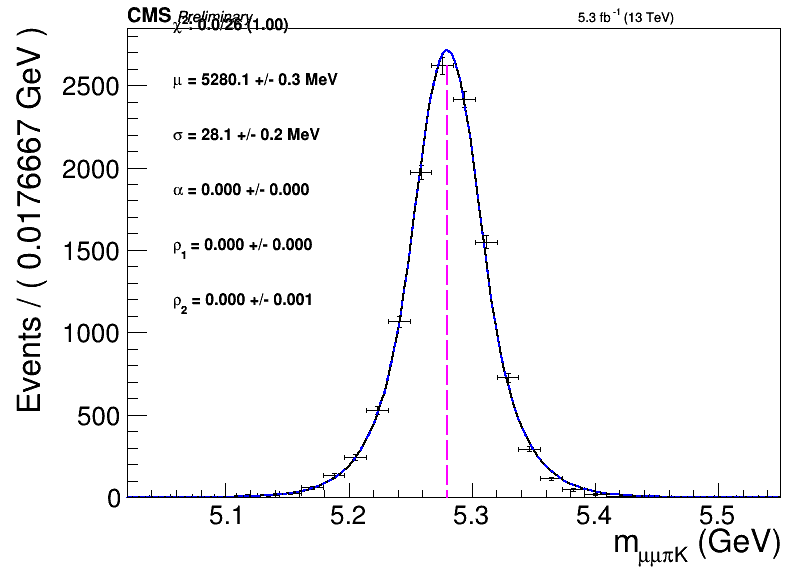

In [92]:
frame = mass.frame(rf.Title(""))
data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), rf.MarkerColor(h.GetLineColor()), rf.LineColor(h.GetLineColor()))
pdf_tot.plotOn(frame, rf.LineColor(h.GetLineColor()), rf.LineWidth(2))
pdf_tot.plotOn(frame, rf.Components('ebkg'), rf.LineColor(rt.kRed), rf.LineWidth(2), rf.LineStyle(7))
pdf_tot.plotOn(frame, rf.Components('esig'), rf.LineColor(rt.kBlue), rf.LineWidth(2), rf.LineStyle(7))

pTxt = rt.TPaveText(5.05, 1000, 5.2, 3000)
pTxt.SetBorderSize(0)
pTxt.SetFillStyle(0)
pTxt.SetTextAlign(11)
pTxt.AddText('#chi^{{2}}: {:.1f}/{:.0f} ({:.2f})'.format(chi2.getVal(), dof, pval))
pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
pTxt.AddText('#sigma = {:.1f} +/- {:.1f} MeV'.format(1e3*sigma.getVal(), 1e3*sigma.getError()))
pTxt.AddText('#alpha = {:.3f} +/- {:.3f}'.format(pAsym.getVal(), pAsym.getError()))
pTxt.AddText('#rho_{{1}} = {:.3f} +/- {:.3f}'.format(rho1.getVal(), rho1.getError()))
pTxt.AddText('#rho_{{2}} = {:.3f} +/- {:.3f}'.format(rho2.getVal(), rho2.getError()))

c = drawOnCMSCanvas(CMS_lumi, frame)
cl.DrawLine(m_B0, 0, m_B0, h.GetMaximum());
pTxt.Draw()

# Compare